# 9.1

## Importeren van Bibliotheken

In [5]:
import pandas
import numpy
import sqlite3 as sql
import matplotlib.pyplot as plt
import random
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Inlezen van de Data

In [6]:
conn = sql.connect("../data/go_sales_train.sqlite")
print(conn)

## Aanmaken van de dataframe

In [7]:
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
table_names = pandas.read_sql(tables_query, conn)['name']

def get_dataframe(table_name):
    dataframe = pandas.read_sql(f"SELECT * FROM {table_name}", conn)
    return dataframe

table_names


0           country
1     order_details
2      order_header
3      order_method
4           product
5      product_line
6      product_type
7     retailer_site
8     return_reason
9     returned_item
10     sales_branch
11      sales_staff
Name: name, dtype: object

## Aanmaken van de dataframe & Selecteren van kolommen

In [8]:
df_order_details = get_dataframe('order_details')
df_returned_item = get_dataframe('returned_item')

merged_dataframe = pandas.merge(
    df_order_details,
    df_returned_item[['ORDER_DETAIL_CODE', 'RETURN_QUANTITY']],
    on='ORDER_DETAIL_CODE',
    how='left'
)

# Vervang 'NULL' met 0
merged_dataframe['RETURN_QUANTITY'] = merged_dataframe['RETURN_QUANTITY'].fillna(0)

# Voeg kolom 'NET_QUANTITY' toe
merged_dataframe['NET_QUANTITY'] = merged_dataframe['QUANTITY'] - merged_dataframe['RETURN_QUANTITY']

# Pak relevante data uit het dataframe
model_dataframe = merged_dataframe.loc[:,['NET_QUANTITY', 'UNIT_SALE_PRICE', 'PRODUCT_NUMBER']]
model_dataframe

,NET_QUANTITY,UNIT_SALE_PRICE,PRODUCT_NUMBER
0,84.0,6.59,1
1,126.0,6.59,1
2,122.0,6.03,1
3,122.0,6.59,1
4,272.0,5.26,1
...,...,...,...
37752,70.0,9.00,112
37753,44.0,9.00,113
37754,8.0,140.00,114
37755,24.0,10.00,115


## Bepalen van de assen

In [9]:
X = model_dataframe.loc[model_dataframe['NET_QUANTITY'].notna(), :]
X = X.drop('NET_QUANTITY', axis = 1)
y = model_dataframe.loc[model_dataframe['NET_QUANTITY'].notna(), ['NET_QUANTITY']]
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37757 entries, 0 to 37756
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UNIT_SALE_PRICE  37757 non-null  float64
 1   PRODUCT_NUMBER   37757 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 884.9 KB


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=42
)

## Regressiemodel bouwen

In [11]:
model = linear_model.LinearRegression()
model = LinearRegression().fit(X_train, y_train)
model

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [12]:
y_pred = model.predict(X_test)
y_pred

array([[15.63682446],
       [56.49447023],
       [58.49956447],
       ...,
       [67.22009792],
       [55.31176645],
       [54.90304698]], shape=(11328, 1))

In [13]:
prediction_dataframe = pandas.DataFrame(y_pred)
prediction_dataframe = prediction_dataframe.rename(columns= {0 : 'Predicted_Sales'})
prediction_dataframe

,Predicted_Sales
0,15.636824
1,56.494470
2,58.499564
3,56.649234
4,58.702573
...,...
11323,62.511819
11324,59.754086
11325,67.220098
11326,55.311766


In [14]:
y_test_prediction_merge = pandas.concat([y_test.reset_index()['NET_QUANTITY'], prediction_dataframe], axis = 1)
y_test_prediction_merge.loc[y_test_prediction_merge['Predicted_Sales'].notna(), :]

,NET_QUANTITY,Predicted_Sales
0,298.0,15.636824
1,24.0,56.494470
2,28.0,58.499564
3,64.0,56.649234
4,192.0,58.702573
...,...,...
11323,44.0,62.511819
11324,150.0,59.754086
11325,38.0,67.220098
11326,54.0,55.311766


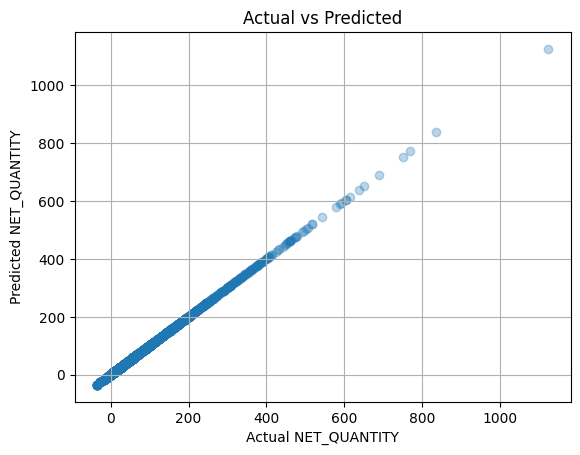

Mean Squared Error: 3192.0401841805547
Mean Absolute Error: 33.7123411399064


In [15]:
plt.scatter(y_test_prediction_merge, y_test_prediction_merge, alpha=0.3)
plt.xlabel('Actual NET_QUANTITY')
plt.ylabel('Predicted NET_QUANTITY')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)